### Multi-Layer Perceptron 

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit

In [141]:
# import the data
df = pd.read_csv('UBS_Cleaned_Date.csv')

In [142]:
# cleaning
df = df.dropna() # to remove NaN
df = df[~(df.isin([np.inf, -np.inf]).any(axis=1))] # to remove inf

In [143]:
# Change "date" column to ensure datetime type and drop weekends
df["date"] = pd.to_datetime(df["date"])

#### MPL With Features From Feature Selection Process

In [144]:
# TimeSeriesSplit the data
tss = TimeSeriesSplit(n_splits=5)

# Create feature dataframe based on feature selection results
X = df[["date", "Change_Close",
            "Wiki_RSI_Move", "Dow_Disparity_Move", 
            "Wiki_MAvg_Move", "Nas_Move",
            "Google_rs", "Google_ROC_Move", 
            "Nas_Disparity_Move", "Google_Disparity_s_Move",
            "Nas_Disparity_s_Move", "Google_gain",
            "Dow_Disparity_s_Move", "Google_RSI_Move", "Google_diff",
            "Dow_Move", "Google_Moment_2_s", "Dow_Rocp", "Nas_gain",
            "Wiki_Disparity_s", "Nas_MAvg_s_Move", "Google_Move",
            "Google_Disparity_s", "Google_total", "UBS_y", "Google_Rocp",
            "target_1"
            ]]

X = X.set_index("date")

# Create y target dataset
y = df["target_1"]

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [145]:
pd.DataFrame(X.isna().sum()).T

,Change_Close,Wiki_RSI_Move,Dow_Disparity_Move,Wiki_MAvg_Move,Nas_Move,Google_rs,Google_ROC_Move,Nas_Disparity_Move,Google_Disparity_s_Move,Nas_Disparity_s_Move,...,Dow_Rocp,Nas_gain,Wiki_Disparity_s,Nas_MAvg_s_Move,Google_Move,Google_Disparity_s,Google_total,UBS_y,Google_Rocp,target_1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [146]:
# Print index of train and test data to check that they are split correctly
print(X_train.index)
print(X_test.index)

DatetimeIndex(['2019-01-28', '2019-01-29', '2019-01-30', '2019-02-01',
               '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07',
               '2019-02-08', '2019-02-11',
               ...
               '2021-09-09', '2021-09-10', '2021-09-14', '2021-09-15',
               '2021-09-16', '2021-09-17', '2021-09-20', '2021-09-21',
               '2021-09-22', '2021-09-23'],
              dtype='datetime64[ns]', name='date', length=624, freq=None)
DatetimeIndex(['2021-09-24', '2021-09-27', '2021-09-28', '2021-09-29',
               '2021-09-30', '2021-10-01', '2021-10-04', '2021-10-05',
               '2021-10-06', '2021-10-07',
               ...
               '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-21',
               '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25',
               '2022-03-28', '2022-03-29'],
              dtype='datetime64[ns]', name='date', length=124, freq=None)


In [147]:
# Standardize the data
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train)
X_test_pca = scaler.fit_transform(X_test)

In [148]:
# Build MPL model
n_features = X_train_pca.shape[1]
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=10)
history

# predict on test data
y_pred = model.predict(X_test)

Epoch 1/50
63/63 [==============================] - 1s 7ms/step - loss: 437.2392 - accuracy: 0.5064 - val_loss: 65.2254 - val_accuracy: 0.5887
Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: 72.6860 - accuracy: 0.5288 - val_loss: 39.1483 - val_accuracy: 0.4919
Epoch 3/50
63/63 [==============================] - 0s 5ms/step - loss: 66.7219 - accuracy: 0.5048 - val_loss: 19.9510 - val_accuracy: 0.4919
Epoch 4/50
63/63 [==============================] - 0s 4ms/step - loss: 43.4590 - accuracy: 0.5385 - val_loss: 51.6309 - val_accuracy: 0.5242
Epoch 5/50
63/63 [==============================] - 0s 5ms/step - loss: 51.8796 - accuracy: 0.4952 - val_loss: 14.5036 - val_accuracy: 0.5645
Epoch 6/50
63/63 [==============================] - 0s 4ms/step - loss: 32.7724 - accuracy: 0.5593 - val_loss: 36.0019 - val_accuracy: 0.5403
Epoch 7/50
63/63 [==============================] - 0s 5ms/step - loss: 22.4844 - accuracy: 0.5321 - val_loss: 30.8538 - val_accuracy: 0.5484
Epoch

<AxesSubplot:>

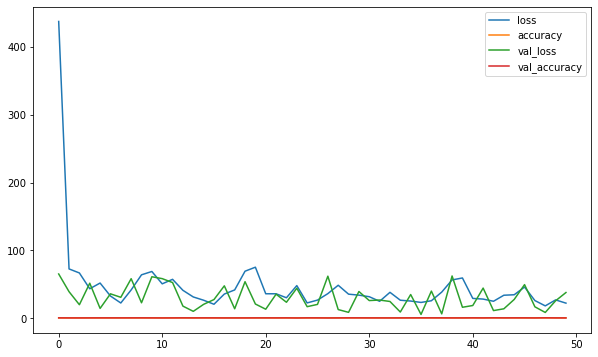

In [149]:
pd.DataFrame(history.history).plot(figsize=(10,6))

#### MPL With PCA For Feature Reduction

In [150]:
# Time series train/test split
tss= TimeSeriesSplit(n_splits=5)

# Keep all features, but remove the five target variables
X = df.iloc[:, :-5]
X = X.set_index("date")

X = X.dropna() # to remove NaN
X = X[~(X.isin([np.inf, -np.inf]).any(axis=1))] # to remove inf

# Create series for target 
y = df.iloc[:, -1]

y = y.dropna() # to remove NaN
#y = y[~(y.isin([np.inf, -np.inf]).any(axis=1))] # to remove inf


# Split tranining and test data by date
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [151]:
# Print index of train and test data to check that they are split correctly
print(X_train.index)
print(X_test.index)

DatetimeIndex(['2019-01-28', '2019-01-29', '2019-01-30', '2019-02-01',
               '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07',
               '2019-02-08', '2019-02-11',
               ...
               '2021-09-09', '2021-09-10', '2021-09-14', '2021-09-15',
               '2021-09-16', '2021-09-17', '2021-09-20', '2021-09-21',
               '2021-09-22', '2021-09-23'],
              dtype='datetime64[ns]', name='date', length=624, freq=None)
DatetimeIndex(['2021-09-24', '2021-09-27', '2021-09-28', '2021-09-29',
               '2021-09-30', '2021-10-01', '2021-10-04', '2021-10-05',
               '2021-10-06', '2021-10-07',
               ...
               '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-21',
               '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25',
               '2022-03-28', '2022-03-29'],
              dtype='datetime64[ns]', name='date', length=124, freq=None)


In [159]:
# PCA feature reduction. 6 components is enough to explain ~85% of the variance (refer to Feture_selection notebook)
sklearn_pca = PCA(n_components=6)
X_train_pca = sklearn_pca.fit_transform(X_train)
X_test_pca = sklearn_pca.transform(X_test)

# Standardize the data 
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.fit_transform(X_test_pca)

In [160]:
# Build MPL model
n_features = X_train_pca.shape[1]
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
history = model.fit(X_train_pca, y_train, epochs=50, validation_data=(X_test_pca, y_test), batch_size=10)
history

# predict on test data
y_pred = model.predict(X_test_pca)

Epoch 1/50
63/63 [==============================] - 3s 20ms/step - loss: 0.6978 - accuracy: 0.5465 - val_loss: 0.7157 - val_accuracy: 0.4919
Epoch 2/50
63/63 [==============================] - 0s 4ms/step - loss: 0.6593 - accuracy: 0.6106 - val_loss: 0.7082 - val_accuracy: 0.5645
Epoch 3/50
63/63 [==============================] - 1s 11ms/step - loss: 0.6391 - accuracy: 0.6250 - val_loss: 0.7077 - val_accuracy: 0.5323
Epoch 4/50
63/63 [==============================] - 0s 7ms/step - loss: 0.6272 - accuracy: 0.6298 - val_loss: 0.7075 - val_accuracy: 0.5242
Epoch 5/50
63/63 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6506 - val_loss: 0.7111 - val_accuracy: 0.5161
Epoch 6/50
63/63 [==============================] - 1s 11ms/step - loss: 0.6164 - accuracy: 0.6490 - val_loss: 0.7123 - val_accuracy: 0.5242
Epoch 7/50
63/63 [==============================] - 0s 6ms/step - loss: 0.6127 - accuracy: 0.6522 - val_loss: 0.7154 - val_accuracy: 0.5242
Epoch 8/50
63/63 

<AxesSubplot:>

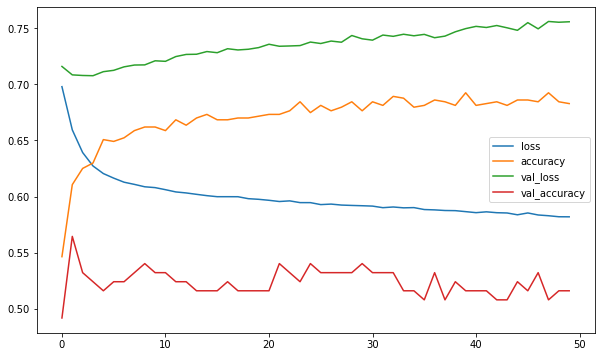

In [161]:
pd.DataFrame(history.history).plot(figsize=(10,6))

### Evaluate model and print metrics

In [155]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

metrics = \
[ \
[accuracy_score(y_train, y_pred), accuracy_score(y_test, y_pred)],
[precision_score(y_train, y_pred), precision_score(y_test, y_pred)], 
[recall_score(y_train, y_pred), recall_score(y_test, y_pred)],
[f1_score(y_train, y_pred), f1_score(y_test, y_pred)]
]
metrics = np.array(metrics) * 100

ValueError: Found input variables with inconsistent numbers of samples: [624, 124]

In [ ]:
metrics = pd.DataFrame(metrics, columns = ["Training Set", "Test Set"])
metrics.insert(0, "Metric", ["Accuracy", "Precision", "Recall", "F1 Score"])
metrics.set_index("Metric", inplace = True)
print(metrics)

           Training Set   Test Set
Metric                            
Accuracy      59.837398  55.194805
Precision     57.940663  56.944444
Recall        98.224852  92.134831
F1 Score      72.886937  70.386266
